In [1]:
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets

### Create data loaders for training, validation, and test sets
def get_loaders():
    train_dir = 'data/train'
    valid_dir = 'data/valid'
    test_dir =  'data/test'

    train_transform = transforms.Compose([transforms.RandomRotation(20),
                                          transforms.RandomResizedCrop(224, scale=(0.09, 1.0), ratio=(1.0, 1.0)),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    valid_transform = transforms.Compose([transforms.Resize(224, interpolation=2),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    test_transform = transforms.Compose([transforms.Resize(224, interpolation=2),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transform)
    test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
    testloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=32)

    loaders = {}
    loaders['train'] = trainloader
    loaders['valid'] = validloader
    loaders['test']  = testloader
    
    label_mapping = ['melanoma', 'nevus', 'seborrheic_keratosis']
    loaders['label_mapping'] = label_mapping
    
    return loaders

def preprocess_image(img_path):
    '''
    Given a path to an image files, returns a tensor that can be used in one of the 
    Pytorch torchvision models
    
    Args:
        img_path: path to an image
        
    Returns:
        A tensor that can be used in one of the Pytorch torchvision models
    '''
    img = Image.open(img_path)

    transform = transforms.Compose([
        transforms.Resize(224, interpolation=2),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img)
    img_tensor = img_tensor.view(1, 3, 224, 224) #add in a dimension for batch size.
    return img_tensor

In [2]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

def get_model(fully_trainable=False):
    # Create model architecture.  Use a pretrained vgg16 model and replace the classifier.
    model = models.vgg16(pretrained=True)

    # Freeze parameters so we don't backprop through them
    if not fully_trainable:
        for name, param in model.named_parameters():
            param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('fc1',    nn.Linear(25088, 512)),
                              ('relu1',   nn.ReLU()),
                              ('drop1',  nn.Dropout(0.25)),
                              ('fc2',    nn.Linear(512, 512)),
                              ('relu2',   nn.ReLU()),
                              ('drop2',  nn.Dropout(0.25)),
                              ('fc3',    nn.Linear(512, 3)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model
    
#print(model_transfer)

In [3]:
import numpy as np

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    valid_loss_min = np.Inf # initialize tracker for minimum validation loss

    if use_cuda:
        print("using GPU for training.")
        model = model.cuda()
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:  # move to GPU
                data, target = data.cuda(), target.cuda()
            
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            #print("data.shape: {}, output.shape: {}, target.shape: {}".format(data.shape, output.shape, target.shape))
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('    Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

In [4]:
#######################
### Train the model ###
#######################
import os

model      = get_model(fully_trainable=True)
model_name = 'skin_tumors_model.pt'
n_epochs   = 50
loaders    = get_loaders()
criterion  = nn.NLLLoss()
optimizer  = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if os.path.exists(model_name):
    #load the saved model from disk
    print("loading saved model: {}".format(model_name))
    model.load_state_dict(torch.load(model_name))

model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, model_name)

using GPU for training.
Epoch: 1 	Training Loss: 0.874769 	Validation Loss: 0.828135
    Validation loss decreased (inf --> 0.828135).  Saving model.
Epoch: 2 	Training Loss: 0.722154 	Validation Loss: 0.885984
Epoch: 3 	Training Loss: 0.709784 	Validation Loss: 0.741718
    Validation loss decreased (0.828135 --> 0.741718).  Saving model.
Epoch: 4 	Training Loss: 0.687006 	Validation Loss: 0.699550
    Validation loss decreased (0.741718 --> 0.699550).  Saving model.
Epoch: 5 	Training Loss: 0.661964 	Validation Loss: 0.735996
Epoch: 6 	Training Loss: 0.655656 	Validation Loss: 0.777318
Epoch: 7 	Training Loss: 0.671956 	Validation Loss: 0.798995
Epoch: 8 	Training Loss: 0.644969 	Validation Loss: 0.726756
Epoch: 9 	Training Loss: 0.639902 	Validation Loss: 0.758102
Epoch: 10 	Training Loss: 0.634921 	Validation Loss: 0.678151
    Validation loss decreased (0.699550 --> 0.678151).  Saving model.
Epoch: 11 	Training Loss: 0.636395 	Validation Loss: 0.730782
Epoch: 12 	Training Loss: 0.

In [5]:
#################################
### Test the model's accuracy ###
#################################
model_name = 'skin_tumors_model.pt'
loaders    = get_loaders()
use_cuda   = torch.cuda.is_available()
criterion  = nn.NLLLoss()
model      = get_model()

if use_cuda:
    model = model.cuda()
model.load_state_dict(torch.load(model_name))
model.eval()

#set in itial values
test_loss = 0.
correct = 0.
total = 0.

for batch_idx, (data, target) in enumerate(loaders['test']):
    # move to GPU
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

print('Test Loss: {:.6f}'.format(test_loss))
print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))


Test Loss: 0.734996
Test Accuracy: 71% (426/600)


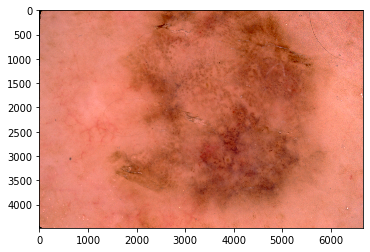

data/test/melanoma/ISIC_0014663.jpg
	melanoma:		87.10%
	nevus:			11.67%
	seborrheic_keratosis:	1.23%


In [19]:
#################################
### Run the model ###############
#################################
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random, os
%matplotlib inline

model_name = 'skin_tumors_model.pt'
use_cuda   = torch.cuda.is_available()
model      = get_model()

def random_file(dir):
    file = os.path.join(dir, random.choice(os.listdir(dir)));
    if os.path.isdir(file):
        return random_file(file)
    else:
        return file
    
test_images_path = 'data/test'
random_file = random_file(test_images_path)

#display the image 
img = cv2.imread(random_file)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#convert the image into a tensor that the model can process
img_tensor = preprocess_image(random_file)
if use_cuda:
    model = model.cuda()
    img_tensor = img_tensor.cuda()
model.load_state_dict(torch.load(model_name))
model.eval()

#get the model's predictions
output = model(img_tensor)
output = output.cpu().detach()

#print the results
label_mapping = ['melanoma', 'nevus', 'seborrheic_keratosis']
print(random_file)
print("\t{}:\t\t{:.2f}%".format(label_mapping[0],   100.*np.exp(output[0][0])))
print("\t{}:\t\t\t{:.2f}%".format(label_mapping[1], 100.*np.exp(output[0][1])))
print("\t{}:\t{:.2f}%".format(label_mapping[2],     100.*np.exp(output[0][2])))
#print( np.exp(output[0][0])+np.exp(output[0][1])+np.exp(output[0][2]) ) #output shoud add up to 1

In [20]:
# Your file should have exactly 3 columns:
# Id - the file names of the test images (in the same order as the sample submission file)
# task_1 - the model's predicted probability that the image (at the path in Id) depicts melanoma
#     in the first category, we will gauge the ability of your CNN to distinguish between malignant melanoma and the benign skin lesions (nevus, seborrheic keratosis) 
# task_2 - the model's predicted probability that the image (at the path in Id) depicts seborrheic keratosis
#    
def get_files(dir, file_list):
    print("getting files in dir: {}".format(dir))
    files = os.listdir(dir)
    files.sort()
    for file in files:
        this_file = os.path.join(dir, file)
        
        if os.path.isdir(this_file):
            get_files(this_file, file_list)
        else:
            file_list.append(this_file)
    return file_list
  
test_file_list = []
test_file_list = get_files('data/test', test_file_list)

model_name = 'skin_tumors_model.pt'
use_cuda   = torch.cuda.is_available()
model      = get_model()

model.load_state_dict(torch.load(model_name))
model.eval()
if use_cuda:
    model = model.cuda()

counter = 0
output_file = open("submission.csv","w+")
output_file.write("Id,task_1,task_2")

for test_image_file in test_file_list:
    counter += 1
    img_tensor = preprocess_image(test_image_file)
    if use_cuda:
        img_tensor = img_tensor.cuda()
        
    #get the model's predictions
    output = model(img_tensor)
    output = output.cpu().detach()
    
    #write the data to the file
    file_output = "{},{},{}".format( test_image_file, np.exp(output[0][0]), np.exp(output[0][2]) )
    print("{}: {}".format(counter, file_output))
    output_file.write("\n")
    output_file.write(file_output)
          
#     if counter > 10:
#         break
    
output_file.close() 

getting files in dir: data/test
getting files in dir: data/test/melanoma
getting files in dir: data/test/nevus
getting files in dir: data/test/seborrheic_keratosis
1: data/test/melanoma/ISIC_0012258.jpg,0.10447622835636139,0.061144836246967316
2: data/test/melanoma/ISIC_0012356.jpg,0.2652990520000458,0.028708448633551598
3: data/test/melanoma/ISIC_0012369.jpg,0.21843832731246948,0.036923669278621674
4: data/test/melanoma/ISIC_0012395.jpg,0.18323944509029388,0.6453453302383423
5: data/test/melanoma/ISIC_0012425.jpg,0.04079698026180267,0.24396514892578125
6: data/test/melanoma/ISIC_0012758.jpg,0.2134934663772583,0.0006137507152743638
7: data/test/melanoma/ISIC_0012989.jpg,0.17374452948570251,0.0016290242783725262
8: data/test/melanoma/ISIC_0013072.jpg,0.4678817689418793,0.1365533173084259
9: data/test/melanoma/ISIC_0013073.jpg,0.455879807472229,0.02938344143331051
10: data/test/melanoma/ISIC_0013242.jpg,0.3291582763195038,0.07466913759708405
11: data/test/melanoma/ISIC_0013277.jpg,0.1794

102: data/test/melanoma/ISIC_0015115.jpg,0.3625186085700989,0.005321563221514225
103: data/test/melanoma/ISIC_0015119.jpg,0.49284669756889343,0.13732750713825226
104: data/test/melanoma/ISIC_0015127.jpg,0.4518967568874359,4.1187457100022584e-05
105: data/test/melanoma/ISIC_0015132.jpg,0.7553166747093201,0.0012400866253301501
106: data/test/melanoma/ISIC_0015133.jpg,0.6869204640388489,0.040147505700588226
107: data/test/melanoma/ISIC_0015136.jpg,0.3621428310871124,0.08785562217235565
108: data/test/melanoma/ISIC_0015142.jpg,0.2021746188402176,0.7392625212669373
109: data/test/melanoma/ISIC_0015156.jpg,0.3355746567249298,0.12930764257907867
110: data/test/melanoma/ISIC_0015163.jpg,0.3312823176383972,0.19769708812236786
111: data/test/melanoma/ISIC_0015167.jpg,0.40375816822052,0.587157666683197
112: data/test/melanoma/ISIC_0015180.jpg,0.14376942813396454,0.4778863489627838
113: data/test/melanoma/ISIC_0015185.jpg,0.11749734729528427,0.4399050772190094
114: data/test/melanoma/ISIC_0015193.

207: data/test/nevus/ISIC_0014868.jpg,0.3934337794780731,0.14691005647182465
208: data/test/nevus/ISIC_0014876.jpg,0.0003502252802718431,0.007193190976977348
209: data/test/nevus/ISIC_0014879.jpg,0.00702681252732873,0.0009432898950763047
210: data/test/nevus/ISIC_0014901.jpg,0.22316788136959076,0.012935180217027664
211: data/test/nevus/ISIC_0014907.jpg,0.05700588971376419,0.0827096700668335
212: data/test/nevus/ISIC_0014910.jpg,0.2551882863044739,0.0054878233931958675
213: data/test/nevus/ISIC_0014921.jpg,0.03649754077196121,0.00032360563636757433
214: data/test/nevus/ISIC_0014927.jpg,0.039270784705877304,0.0002066707529593259
215: data/test/nevus/ISIC_0014936.jpg,0.26164892315864563,0.0011421320959925652
216: data/test/nevus/ISIC_0014938.jpg,0.9873374104499817,5.122740986962526e-08
217: data/test/nevus/ISIC_0014940.jpg,0.07635410875082016,0.00041984289418905973
218: data/test/nevus/ISIC_0014941.jpg,0.07546274363994598,3.3239506592508405e-05
219: data/test/nevus/ISIC_0014942.jpg,0.0234

312: data/test/nevus/ISIC_0015254.jpg,0.05373922362923622,2.9312537662917748e-05
313: data/test/nevus/ISIC_0015255.jpg,0.4094499945640564,0.03311799094080925
314: data/test/nevus/ISIC_0015258.jpg,0.18124131858348846,0.00022842010366730392
315: data/test/nevus/ISIC_0015264.jpg,0.05846976116299629,0.5409519672393799
316: data/test/nevus/ISIC_0015270.jpg,0.2397574931383133,0.003840360324829817
317: data/test/nevus/ISIC_0015273.jpg,0.12582531571388245,0.17204102873802185
318: data/test/nevus/ISIC_0015274.jpg,0.39102670550346375,0.04377823695540428
319: data/test/nevus/ISIC_0015276.jpg,0.12856623530387878,0.026302216574549675
320: data/test/nevus/ISIC_0015279.jpg,0.13266824185848236,0.08527491241693497
321: data/test/nevus/ISIC_0015283.jpg,0.05973707512021065,0.000297072489047423
322: data/test/nevus/ISIC_0015291.jpg,0.10386835038661957,0.15509295463562012
323: data/test/nevus/ISIC_0015293.jpg,0.09883036464452744,0.18538343906402588
324: data/test/nevus/ISIC_0015298.jpg,0.075565867125988,0.

417: data/test/nevus/ISIC_0015971.jpg,0.07395248860120773,0.021596059203147888
418: data/test/nevus/ISIC_0015972.jpg,0.0015020648716017604,0.8432971239089966
419: data/test/nevus/ISIC_0015973.jpg,0.06252281367778778,0.05650404095649719
420: data/test/nevus/ISIC_0015974.jpg,0.1303253024816513,0.5049276351928711
421: data/test/nevus/ISIC_0015975.jpg,0.009601102210581303,0.0016783580649644136
422: data/test/nevus/ISIC_0015976.jpg,0.22461016476154327,0.08313307911157608
423: data/test/nevus/ISIC_0015978.jpg,0.018391761928796768,0.3571491539478302
424: data/test/nevus/ISIC_0015979.jpg,0.05051752179861069,0.7495548129081726
425: data/test/nevus/ISIC_0015980.jpg,0.03647613152861595,0.07902996987104416
426: data/test/nevus/ISIC_0015981.jpg,0.19011692702770233,0.022661730647087097
427: data/test/nevus/ISIC_0015982.jpg,0.01385226659476757,0.03194296360015869
428: data/test/nevus/ISIC_0015983.jpg,0.06768640875816345,0.807731032371521
429: data/test/nevus/ISIC_0015984.jpg,0.007325409911572933,0.20

521: data/test/seborrheic_keratosis/ISIC_0012265.jpg,0.2743421792984009,0.38120952248573303
522: data/test/seborrheic_keratosis/ISIC_0012266.jpg,0.1939142644405365,0.45489582419395447
523: data/test/seborrheic_keratosis/ISIC_0012272.jpg,1.0964738976326771e-05,0.001267937826924026
524: data/test/seborrheic_keratosis/ISIC_0012273.jpg,0.264505535364151,0.34038037061691284
525: data/test/seborrheic_keratosis/ISIC_0012314.jpg,0.011590266600251198,0.34763303399086
526: data/test/seborrheic_keratosis/ISIC_0012323.jpg,0.008729281835258007,0.9839339852333069
527: data/test/seborrheic_keratosis/ISIC_0012330.jpg,0.00873544067144394,1.1727357559720986e-05
528: data/test/seborrheic_keratosis/ISIC_0012358.jpg,0.2042965441942215,0.39987578988075256
529: data/test/seborrheic_keratosis/ISIC_0012364.jpg,0.14809352159500122,0.5973674654960632
530: data/test/seborrheic_keratosis/ISIC_0012372.jpg,0.019782064482569695,0.41037657856941223
531: data/test/seborrheic_keratosis/ISIC_0012375.jpg,0.075958997011184